In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms
from torchvision.models import ResNet18_Weights
from torchvision.models import ResNet50_Weights
from torchvision.models import ResNet101_Weights
from torchvision.models import ResNet152_Weights
from torch.optim.lr_scheduler import StepLR
import time
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image

In [127]:
print(torch.cuda.is_available())
print(torch.__version__)

True
2.1.0.dev20230825+cu121


In [128]:
transforms_wt = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

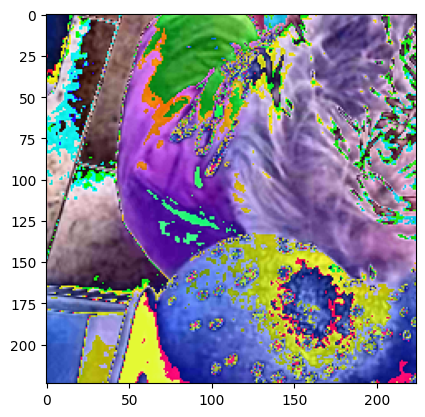

In [129]:
orig_set = datasets.ImageFolder(
    root='./data/test_03',
    transform=transforms_wt
)
data, label = orig_set[100]
transform_test = T.ToPILImage()
plt.imshow(transform_test(data))


In [130]:
orig_set.classes

['duoballs', 'trigger']

In [131]:
len(orig_set)

4843

In [132]:
data, label = orig_set[0]
print(data.size())

torch.Size([3, 224, 224])


In [133]:
import torch
from torch.utils.data import random_split, DataLoader

data_loader = DataLoader(orig_set, batch_size=len(orig_set), shuffle=True)

# Define the dataset size
dataset_size = len(orig_set)

# Calculate the sizes for training, validation, and test sets
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into training, validation, and test sets
train_set, val_set, test_set = random_split(orig_set, [train_size, val_size, test_size])

In [134]:
val_data, val_label = val_set[1]
print(val_data.size())

torch.Size([3, 224, 224])


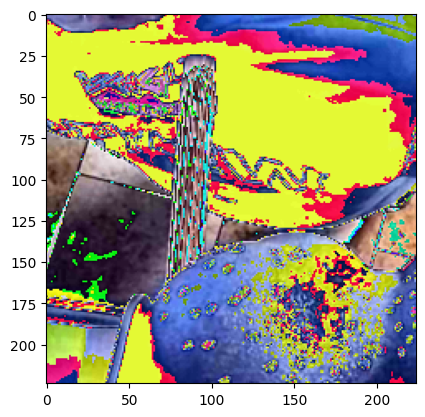

In [135]:
transform = T.ToPILImage()
plt.imshow(transform(val_data))

In [136]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=8,
    shuffle=True,
    num_workers=16
)

In [137]:
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=8,
    shuffle=True,
    num_workers=16
)

In [138]:
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=8,
    shuffle=True,
    num_workers=16
)

In [139]:
model = models.resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)

print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)
print(model.fc)

In [140]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2048),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(2048,1024),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(1024,500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500,2)
)
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=2048, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=2048, out_features=1024, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=1024, out_features=500, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=500, out_features=2, bias=True)
)


In [141]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [142]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

In [143]:
start_time = time.time()

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()/inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)/inputs.size(0)


    exp_lr_scheduler.step()
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)

    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() / inputs.size(0)
        running_corrects += torch.sum(preds == labels.data) / inputs.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)
    print(f"Epoch: {epoch}: Train: Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f} Val: Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

end_time = time.time()
print("Time:", end_time - start_time)

Epoch: 0: Train: Loss: 0.0330 Acc: 0.9639 Val: Loss: 0.1134 Acc: 0.8233
Epoch: 1: Train: Loss: 0.0133 Acc: 0.9890 Val: Loss: 0.0044 Acc: 0.9990
Epoch: 2: Train: Loss: 0.0059 Acc: 0.9928 Val: Loss: 0.0001 Acc: 0.9990
Epoch: 3: Train: Loss: 0.4919 Acc: 0.9904 Val: Loss: 0.0001 Acc: 1.0000
Epoch: 4: Train: Loss: 0.0579 Acc: 0.8953 Val: Loss: 0.0970 Acc: 0.9597
Time: 3726.9639010429382


In [144]:
torch.save(model.state_dict(), "./trigger_duoballs_moddel_03.pt")

test_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=4,
    shuffle=True,
    num_workers=16
)

In [145]:
num_correct = 0.0
for inputs, labels in test_loader:
    model.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    predict_label = model(inputs)
    _, predicted = torch.max(predict_label,1)
    num_correct += (predicted == labels).float().sum()

    accuracy = num_correct/(len(test_loader)*test_loader.batch_size)

    print(len(test_loader), test_loader.batch_size)
    print("Test Accuracy: {}".format(accuracy))

122 8
Test Accuracy: 0.008196720853447914
122 8
Test Accuracy: 0.016393441706895828
122 8
Test Accuracy: 0.024590162560343742
122 8
Test Accuracy: 0.032786883413791656
122 8
Test Accuracy: 0.04098360240459442
122 8
Test Accuracy: 0.049180325120687485
122 8
Test Accuracy: 0.05737704783678055
122 8
Test Accuracy: 0.06557376682758331
122 8
Test Accuracy: 0.07377048581838608
122 8
Test Accuracy: 0.08196720480918884
122 8
Test Accuracy: 0.0901639312505722
122 8
Test Accuracy: 0.09836065024137497
122 8
Test Accuracy: 0.10655736923217773
122 8
Test Accuracy: 0.1147540956735611
122 8
Test Accuracy: 0.12295081466436386
122 8
Test Accuracy: 0.13114753365516663
122 8
Test Accuracy: 0.13934426009655
122 8
Test Accuracy: 0.14754097163677216
122 8
Test Accuracy: 0.15573769807815552
122 8
Test Accuracy: 0.16290982067584991
122 8
Test Accuracy: 0.17110654711723328
122 8
Test Accuracy: 0.17930327355861664
122 8
Test Accuracy: 0.1874999850988388
122 8
Test Accuracy: 0.19364753365516663
122 8
Test Accura

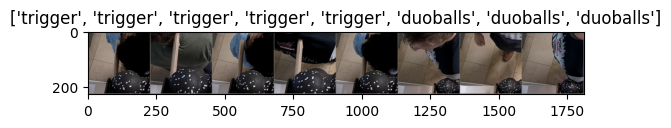

In [146]:
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

def print_grid():
    inputs, classes = next(iter(test_loader))
    out = torchvision.utils.make_grid(inputs)
    class_names = orig_set.classes

    outputs = model(inputs.to(device))
    _, preds = torch.max(outputs, 1)

    imshow(out, title=[class_names[x] for x in preds])

print_grid()